In [4]:
import os
import cv2
import imageio.v3 as imageio
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
import sys
# sys.path.append("FracTAL_ResUNet/)
sys.path.append("../GitHub/FracTAL_ResUNet/")
from tqdm.auto import tqdm
from scipy.ndimage import distance_transform_edt

# import visdom
# sys.path.append('resuneta/') # do we need this repo?
# sys.path.append('../../')

# from resuneta.bound_dist import get_distance, get_boundary

# from bound_dist import get_distance, get_boundary
# from loss import TanimotoDualLoss
# from resuneta.models.resunet_d6_causal_mtskcolor_ddist import *
# from nn.loss.mtsk_loss import mtsk_loss

from models.semanticsegmentation.FracTAL_ResUNet import FracTAL_ResUNet_cmtsk

from sklearn.metrics import f1_score, matthews_corrcoef

import matplotlib.pyplot as plt
# %matplotlib inline

# Res Unet for test

In [5]:
# import torch.nn.functional as F
# from torch.nn import Module, Conv2d, Parameter, Softmax
# from torchvision.models import resnet
# import torch
# from torchvision import models
# from torch import nn

# from functools import partial


# nonlinearity = partial(F.relu, inplace=True)


# def softplus_feature_map(x):
#     return torch.nn.functional.softplus(x)


# def conv3otherRelu(in_planes, out_planes, kernel_size=None, stride=None, padding=None):
#     # 3x3 convolution with padding and relu
#     if kernel_size is None:
#         kernel_size = 3
#     assert isinstance(kernel_size, (int, tuple)), 'kernel_size is not in (int, tuple)!'

#     if stride is None:
#         stride = 1
#     assert isinstance(stride, (int, tuple)), 'stride is not in (int, tuple)!'

#     if padding is None:
#         padding = 1
#     assert isinstance(padding, (int, tuple)), 'padding is not in (int, tuple)!'

#     return nn.Sequential(
#         nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
#         nn.ReLU(inplace=True)  # inplace=True
#     )


# class PAM_Module(Module):
#     def __init__(self, in_places, scale=8, eps=1e-6):
#         super(PAM_Module, self).__init__()
#         self.gamma = Parameter(torch.zeros(1))
#         self.in_places = in_places
#         self.softplus_feature = softplus_feature_map
#         self.eps = eps

#         self.query_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
#         self.key_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
#         self.value_conv = Conv2d(in_channels=in_places, out_channels=in_places, kernel_size=1)

#     def forward(self, x):
#         # Apply the feature map to the queries and keys
#         batch_size, chnnels, width, height = x.shape
#         Q = self.query_conv(x).view(batch_size, -1, width * height)
#         K = self.key_conv(x).view(batch_size, -1, width * height)
#         V = self.value_conv(x).view(batch_size, -1, width * height)

#         Q = self.softplus_feature(Q).permute(-3, -1, -2)
#         K = self.softplus_feature(K)

#         KV = torch.einsum("bmn, bcn->bmc", K, V)

#         norm = 1 / torch.einsum("bnc, bc->bn", Q, torch.sum(K, dim=-1) + self.eps)

#         # weight_value = torch.einsum("bnm, bmc, bn->bcn", Q, KV, norm)
#         weight_value = torch.einsum("bnm, bmc, bn->bcn", Q, KV, norm)
#         weight_value = weight_value.view(batch_size, chnnels, height, width)

#         return (x + self.gamma * weight_value).contiguous()


# class CAM_Module(Module):
#     def __init__(self):
#         super(CAM_Module, self).__init__()
#         self.gamma = Parameter(torch.zeros(1))
#         self.softmax = Softmax(dim=-1)

#     def forward(self, x):
#         batch_size, chnnels, width, height = x.shape
#         proj_query = x.view(batch_size, chnnels, -1)
#         proj_key = x.view(batch_size, chnnels, -1).permute(0, 2, 1)
#         energy = torch.bmm(proj_query, proj_key)
#         energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy) - energy
#         attention = self.softmax(energy_new)
#         proj_value = x.view(batch_size, chnnels, -1)

#         out = torch.bmm(attention, proj_value)
#         out = out.view(batch_size, chnnels, height, width)

#         out = self.gamma * out + x
#         return out


# class PAM_CAM_Layer(nn.Module):
#     def __init__(self, in_ch):
#         super(PAM_CAM_Layer, self).__init__()
#         self.PAM = PAM_Module(in_ch)
#         self.CAM = CAM_Module()

#     def forward(self, x):
#         return self.PAM(x) + self.CAM(x)


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, n_filters):
#         super(DecoderBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
#         self.norm1 = nn.BatchNorm2d(in_channels // 4)
#         self.relu1 = nonlinearity

#         self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
#         self.norm2 = nn.BatchNorm2d(in_channels // 4)
#         self.relu2 = nonlinearity

#         self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
#         self.norm3 = nn.BatchNorm2d(n_filters)
#         self.relu3 = nonlinearity

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.norm1(x)
#         x = self.relu1(x)
#         x = self.deconv2(x)
#         x = self.norm2(x)
#         x = self.relu2(x)
#         x = self.conv3(x)
#         x = self.norm3(x)
#         x = self.relu3(x)
#         return x


# class MANet(nn.Module):
#     def __init__(self, num_channels=3, num_classes=5):
#         super(MANet, self).__init__()
#         self.name = 'MANet'

#         filters = [256, 512, 1024, 2048]
#         resnet = models.resnet50(pretrained=True)
#         self.firstconv = resnet.conv1
#         self.firstbn = resnet.bn1
#         self.firstrelu = resnet.relu
#         self.firstmaxpool = resnet.maxpool
#         self.encoder1 = resnet.layer1
#         self.encoder2 = resnet.layer2
#         self.encoder3 = resnet.layer3
#         self.encoder4 = resnet.layer4

#         self.attention4 = PAM_CAM_Layer(filters[3])
#         self.attention3 = PAM_CAM_Layer(filters[2])
#         self.attention2 = PAM_CAM_Layer(filters[1])
#         self.attention1 = PAM_CAM_Layer(filters[0])

#         self.decoder4 = DecoderBlock(filters[3], filters[2])
#         self.decoder3 = DecoderBlock(filters[2], filters[1])
#         self.decoder2 = DecoderBlock(filters[1], filters[0])
#         self.decoder1 = DecoderBlock(filters[0], filters[0])

#         self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
#         self.finalrelu1 = nonlinearity
#         self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
#         self.finalrelu2 = nonlinearity
#         self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

#     def forward(self, x):
#         # Encoder
#         x1 = self.firstconv(x)
#         x1 = self.firstbn(x1)
#         x1 = self.firstrelu(x1)
#         x1 = self.firstmaxpool(x1)
#         e1 = self.encoder1(x1)
#         e2 = self.encoder2(e1)
#         e3 = self.encoder3(e2)
#         e4 = self.encoder4(e3)

#         e4 = self.attention4(e4)

#         # Decoder
#         d4 = self.decoder4(e4) + self.attention3(e3)
#         d3 = self.decoder3(d4) + self.attention2(e2)
#         d2 = self.decoder2(d3) + self.attention1(e1)
#         d1 = self.decoder1(d2)

#         out = self.finaldeconv1(d1)
#         out = self.finalrelu1(out)
#         out = self.finalconv2(out)
#         out = self.finalrelu2(out)
#         out = self.finalconv3(out)

#         return out


# if __name__ == '__main__':
#     num_classes = 2
#     in_batch, inchannel, in_h, in_w = 8, 3, 256, 256
#     x = torch.randn(in_batch, inchannel, in_h, in_w)
#     net = MANet(3, num_classes)
#     out = net(x)
#     print(out.shape)

# ftnmt_loss

In [6]:
class ftnmt_loss(torch.nn.Module):
    def __init__(self, depth=5, axis=[1, 2, 3], smooth=1.0e-5, **kwargs):
        super(ftnmt_loss, self).__init__(**kwargs)

        assert depth >= 0, ValueError("depth must be >= 0, aborting...")

        self.smooth = smooth
        self.axis = axis
        self.depth = depth

        if depth == 0:
            self.depth = 1
            self.scale = 1.
        else:
            self.depth = depth
            self.scale = 1. / depth

    def inner_prod(self, prob, label):
        prod = prob * label
        prod = torch.sum(prod, dim=self.axis)
        return prod

    def tnmt_base(self, preds, labels):

        tpl = self.inner_prod(preds, labels)
        tpp = self.inner_prod(preds, preds)
        tll = self.inner_prod(labels, labels)

        num = tpl + self.smooth
        scale = 1. / self.depth
        denum = 0.0
        for d in range(self.depth):
            a = 2. ** d
            b = -(2. * a - 1.)

            denum = denum + torch.reciprocal(a * (tpp + tll) + b * tpl + self.smooth)

        result = num * denum * scale
        return torch.mean(result, dim=0)

    def forward(self, preds, labels):

        l1 = self.tnmt_base(preds, labels)
        l2 = self.tnmt_base(1. - preds, 1. - labels)

        result = 0.5 * (l1 + l2)

        return 1. - result


class ftnmt_loss_masked(nn.Module):
    def __init__(self, depth=5, axis=[1,2,3], smooth=1.0e-5):
        super(ftnmt_loss_masked, self).__init__()

        assert depth >= 0, ValueError("depth must be >= 0, aborting...")

        self.smooth = smooth
        self.axis = axis
        self.depth = depth

        if depth == 0:
            self.depth = 1
            self.scale = 1.
        else:
            self.depth = depth
            self.scale = 1./depth

    def inner_prod(self, prob, label):
        prod = prob * label
        prod = torch.sum(prod, dim=self.axis)
        return prod

    def tnmt_base(self, preds, labels):

        tpl = self.inner_prod(preds, labels)
        tpp = self.inner_prod(preds, preds)
        tll = self.inner_prod(labels, labels)

        num = tpl + self.smooth
        scale = 1./self.depth
        denum = 0.0

        for d in range(self.depth):
            a = 2.**d
            b = -(2.*a-1.)

            denum = denum + torch.reciprocal(a*(tpp+tll) + b * tpl + self.smooth)

        result = num * denum * scale
        return torch.mean(result, dim=0)

    def forward(self, preds, labels, mask):

        preds = preds * mask

        preds_dual = 1. - preds
        labels_dual = 1. - labels
        preds_dual = preds_dual * mask
        labels_dual = labels_dual * mask

        l1 = self.tnmt_base(preds, labels)
        l2 = self.tnmt_base(preds_dual, labels_dual)

        result = 0.5 * (l1 + l2)

        return 1. - result

# Dataloader

In [7]:
class PlanetDatasetWithClassesFullPathsMasked(Dataset):

    def __init__(self, fold='train', image_names=None, label_names=None, classes=[1],
                 noncrop_classes=[2], boundary_kernel_size=(3, 3)):

        self.fold = fold
        self.classes = classes
        self.noncrop_classes = noncrop_classes
        self.image_names = image_names
        self.label_names = label_names
        self.boundary_kernel_size = boundary_kernel_size

    def __getitem__(self, item):
        image = np.zeros((256, 256, 3))
        image_path = self.image_names[item]
        image_temp = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        nrow, ncol, nchannels = image_temp.shape

        extent_path = self.label_names[item]
        extent_mask = np.zeros((256, 256))
        extent_original = imageio.imread(extent_path)
        nrow, ncol = extent_original.shape
        extent_image = np.array(np.isin(extent_original, self.classes), dtype=np.uint8)

        topleft_x, topleft_y = 0, 0
        if nrow > 256:
            topleft_x = np.random.choice(np.arange(0, nrow-256))
        if ncol > 256:
            topleft_y = np.random.choice(np.arange(0, ncol-256))

        image[:nrow, :ncol] = image_temp[topleft_x:topleft_x+256, topleft_y:topleft_y+256]
        extent_mask[:nrow, :ncol] = extent_image[topleft_x:topleft_x+256, topleft_y:topleft_y+256]

        noncrop_mask = np.zeros((256, 256))
        noncrop_image = np.array(np.isin(extent_original, self.noncrop_classes), dtype=np.uint8)
        noncrop_mask[:nrow, :ncol] = noncrop_image[topleft_x:topleft_x+256, topleft_y:topleft_y+256]

        if self.fold == 'train':
            # brightness augmentation
            image = np.minimum(np.random.uniform(low=0.8, high=1.25) * image, 255)

            # rotation augmentation
            k = np.random.randint(low=0, high=4)
            image = np.rot90(image, k, axes=(0,1))
            extent_mask = np.rot90(extent_mask, k, axes=(0,1))

            # flip augmentation
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=0)
                extent_mask = np.flip(extent_mask, axis=0)
            if np.random.uniform() > 0.5:
                image = np.flip(image, axis=1)
                extent_mask = np.flip(extent_mask, axis=1)

        image = image.astype(np.uint8)
        boundary_mask = get_boundary(extent_mask, kernel_size=self.boundary_kernel_size)
        distance_mask = get_distance(extent_mask)
        # image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        # Define label mask
        label_mask = np.array((extent_mask + boundary_mask + noncrop_mask) >= 1, dtype=np.float32)

        image = transforms.ToTensor()(image)
        # image_hsv = torch.tensor(image_hsv.transpose(2, 0, 1) / 255.0, dtype=torch.float32)
        
        # Create copies of the numpy arrays to ensure positive strides
        extent_mask_copy = extent_mask.copy()
        boundary_mask_copy = boundary_mask.copy()
        distance_mask_copy = distance_mask.copy()
        label_mask_copy = label_mask.copy()

        # Now convert the copied numpy arrays to tensors and unsqueeze
        extent_mask = torch.unsqueeze(torch.tensor(extent_mask_copy, dtype=torch.float32), 0)
        boundary_mask = torch.unsqueeze(torch.tensor(boundary_mask_copy, dtype=torch.float32), 0)
        distance_mask = torch.unsqueeze(torch.tensor(distance_mask_copy, dtype=torch.float32), 0)
        label_mask = torch.unsqueeze(torch.tensor(label_mask_copy, dtype=torch.float32), 0)
        
        return image, extent_mask, boundary_mask, distance_mask, label_mask

    def __len__(self):
        return len(self.image_names)
    
def get_boundary(mask, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=1)
    return dilation - mask

def get_distance(mask):
    return distance_transform_edt(mask)

# Parse data

In [15]:
   # Run the training and evaluation
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
# from sklearn.metrics import confusion_matrix

# ============================ #
# user-specified hyperparameters
# ============================ #
country = 'partial-france'
epochs = 100
lr = 0.001
lr_decay = None
n_filters = 32
depth = 6
n_classes = 1
batch_size = 8
model_type = 'fractal-resunet'  # 'resunet-d6'
month_name = '3month-separate'
codes_to_keep = list(range(1, 10)) + [11, 14, 15, 16, 17, 18, 19, 21, 24, 25, 26, 28]
ctx_name = 'gpu' #'gpu'
gpu_id = 0
boundary_kernel_size = (2, 2)



# trained_model = '../experiments/france/sherrie10k/' + \
#     'resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/model.params'
trained_model = None
# splits_path = '../data/splits/sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv'
splits_path = '../sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv' # THIS NEEDS TO BE CREATED
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)

# get all img and labels
all_img_names = []
all_label_names = []
img_dir = '../data/image/3x_downsample/'
label_dir = '../data/label/3x_downsample/'
# img_dir = '../GitHub/FracTAL_ResUNet/data/france/images/'
# label_dir = '../GitHub/FracTAL_ResUNet/data/france/labels/'
# subfolders = ['2x_downsample', '3x_downsample']

# for subfolder in subfolders:
#     label_folder_imgs = sorted(os.listdir(os.path.join(label_dir, subfolder)))
for label_name in sorted(os.listdir(label_dir)):
    for month in ["2019_04", "2019_07", "2019_10"]:
        img_name = label_name.split('.')[0] + '_' + month + '.tif'
        img_path = os.path.join(img_dir, img_name)
        all_img_names.append(img_path)
        label_path = os.path.join(label_dir, label_name)
        all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[0])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names = all_images[all_images['fold'] == 'train']['img_path'].values
val_names = all_images[all_images['fold'] == 'val']['img_path'].values
test_names = all_images[all_images['fold'] == 'test']['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names_label = all_labels[all_labels['fold'] == 'train']['label_path'].values
val_names_label = all_labels[all_labels['fold'] == 'val']['label_path'].values
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values 

train_dataset = PlanetDatasetWithClassesFullPathsMasked(
    fold='train',
    image_names=train_names,
    label_names=train_names_label,
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)
val_dataset = PlanetDatasetWithClassesFullPathsMasked(
    fold='val',
    image_names=val_names,
    label_names=val_names_label,
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)
test_dataset = PlanetDatasetWithClassesFullPathsMasked(
    fold='test',
    image_names=test_names,
    label_names=test_names_label,
    classes=codes_to_keep,
    boundary_kernel_size=boundary_kernel_size)

# Initialization

In [16]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import f1_score, matthews_corrcoef
import numpy as np
from torch.utils.tensorboard import SummaryWriter

# Initialize the dataset and dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, norm_groups=1, depth=depth, NClasses=n_classes)
dummy_input = torch.randn(8,3,256,256)
model(dummy_input)
model = nn.DataParallel(model)
model.to(device)
loss_function = ftnmt_loss_masked()
optimizer = Adam(model.parameters(), lr=0.001)
torch.backends.cudnn.enabled = False

writer = SummaryWriter('runs/experiment_France_3x')

# Function to calculate Dice coefficient
# def dice_coeff(preds, labels):
#     preds = preds > 0.5  # Convert to binary
#     labels = labels > 0.5
#     intersection = (preds & labels).float().sum((1, 2))
#     union = (preds | labels).float().sum((1, 2))
#     dice = (2. * intersection + 1e-6) / (union + 1e-6)
#     return dice.mean().item()

Hello
32
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


/home/kai_ma/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Train model

In [7]:
num_epochs = 100 # Set the number of epochs

for epoch in range(num_epochs):
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    # Initialize metrics
    total_loss = 0
    total_f1 = 0
    total_mcc = 0
    total_accuracy = 0
    num_batches = 0

    for batch_idx, (image, extent, boundary, distance, mask) in enumerate(train_loader_tqdm):  
        image, extent, boundary, distance, mask = image.to(device), extent.to(device), boundary.to(device), distance.to(device), mask.to(device)
        optimizer.zero_grad()
        logit, bound, dist= model(image)
        loss1 = loss_function(logit, extent, mask)
        loss2 = loss_function(bound, boundary, mask)
        loss3 = loss_function(dist, distance, mask)

        loss = 0.33 * (loss1 + loss2 + loss3)

        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1

        # Calculate and accumulate metrics
        predictions = (logit > 0.5).float()  # Convert to 0/1 predictions
        target_1d = extent.flatten()
        predictions_1d = predictions.flatten()
        total_f1 += f1_score(target_1d.cpu().numpy(), predictions_1d.cpu().numpy())
        total_mcc += matthews_corrcoef(target_1d.cpu().numpy(), predictions_1d.cpu().numpy())
        total_accuracy += (predictions_1d == target_1d).sum().item() / target_1d.size(0)

        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

    # Calculate average metrics
    avg_loss = total_loss / num_batches
    avg_f1 = total_f1 / num_batches
    avg_mcc = total_mcc / num_batches
    avg_accuracy = total_accuracy / num_batches

    # Log metrics after each epoch
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('F1/train', avg_f1, epoch)
    writer.add_scalar('MCC/train', avg_mcc, epoch)
    writer.add_scalar('Accuracy/train', avg_accuracy, epoch)

    # Print epoch summary
    print(f"End of Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}, Avg F1: {avg_f1:.4f}, Avg MCC: {avg_mcc:.4f}, Avg Accuracy: {avg_accuracy:.4f}")


    # Start evaluation
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_f1 = 0
        total_mcc = 0
        total_dice = 0
        total_accuracy = 0
        num_batches = 0

        for (image, extent, boundary, distance, mask) in (val_loader): # used to be train_loader, a mismatch of val_loader in training...
            image, extent, boundary, distance, mask = image.to(device), extent.to(device), boundary.to(device), distance.to(device), mask.to(device)

            logit, bound, dist= model(image)
            loss1 = loss_function(logit, extent, mask)
            loss2 = loss_function(bound, boundary, mask)
            loss3 = loss_function(dist, distance, mask)
            total_loss += loss.item()

            # Calculate metrics
            predictions = (logit > 0.5).float()  # Convert to 0/1 predictions
            target_1d = extent.flatten()
            predictions_1d = predictions.flatten()
            total_f1 += f1_score(target_1d.cpu().numpy(), predictions_1d.cpu().numpy())
            total_mcc += matthews_corrcoef(target_1d.cpu().numpy(), predictions_1d.cpu().numpy())
            total_accuracy += (predictions_1d == target_1d).sum().item() / target_1d.size(0)

            num_batches += 1

        # Calculate average metrics
        avg_loss = total_loss / num_batches
        avg_f1 = total_f1 / num_batches
        avg_mcc = total_mcc / num_batches
        avg_accuracy = total_accuracy / num_batches

        # Log metrics
        writer.add_scalar('Loss/val', avg_loss, epoch)
        writer.add_scalar('F1/val', avg_f1, epoch)
        writer.add_scalar('MCC/val', avg_mcc, epoch)
        writer.add_scalar('Accuracy/val', avg_accuracy, epoch)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, F1: {avg_f1:.4f}, MCC: {avg_mcc:.4f}, Accuracy: {avg_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), "old_model.pth")
writer.close()


Epoch 1/100 - Loss: 0.7925:   1%|          | 13/2534 [00:21<1:08:43,  1.64s/batch]


KeyboardInterrupt: 

# Visualize the predictions

In [10]:
model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, norm_groups=1, depth=depth, NClasses=n_classes)
dummy_input = torch.randn(8,3,256,256)
model(dummy_input)
file_name = './old_model.pth'
model_name = 'france_3x'

model.load_state_dict(torch.load(file_name), strict=False)
model.eval()


Hello
32
depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


FracTAL_ResUNet_cmtsk(
  (features): FracTAL_ResUNet_features(
    (conv_first): Conv2DNormed(
      (conv2d): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm_layer): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convs_dn): ModuleList(
      (0): Sequential(
        (FracTALResNet_unit): FracTALResNet_unit(
          (block1): ResNet_v2_block(
            (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
          )
          (attn): FTAttention2D(
            (att): RelFTAttention2D(
              (query): Conv2DNormed(
                (conv2d): Conv2d(32, 32, kernel_size=(3, 3), 

In [134]:
# months = ['2019_{}'.format(str(x).zfill(2)) for x in [4, 7, 10]]
# for month in months:
#     save_dir = './results/partial-france/{}/{}'.format(model_name, month)

#     if not os.path.exists(save_dir):
#         os.makedirs(os.path.join(save_dir, 'predictions'))
#         # os.makedirs(os.path.join(save_dir, 'extent_predictions'))

# with torch.no_grad():
#     for batch_i, (img, extent, boundary, distance, mask)in enumerate(test_loader):
#         img, mask = img.to(device), mask.to(device)
#         pred, bound, dist = model(img)

#         for i in range(pred[0].shape[0]):
#             save_month = '_'.join(val_names[batch_i * batch_size + i].split('/')[-1].split('.')[0].split('_')[1:3])
#             save_dir = os.path.join('./results/partial-france/{}'.format(model_name), save_month)
#             image_id = val_names[batch_i * batch_size + i].split('/')[-1].split('_')[0]

#             # Create directories if they don't exist
#             pred_dir = os.path.join(save_dir, 'predictions')
#             # extent_dir = os.path.join(save_dir, 'extent_predictions')
#             # os.makedirs(boundary_dir, exist_ok=True)
#             # os.makedirs(extent_dir, exist_ok=True)
#             array = pred[0][i][0].cpu().numpy()
#             # Save the numpy files
#             np.save(os.path.join(pred_dir, '{}.npy'.format(image_id)), array)

KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: './results/partial-france/france_3x/2019_04/predictions/00060.npy'

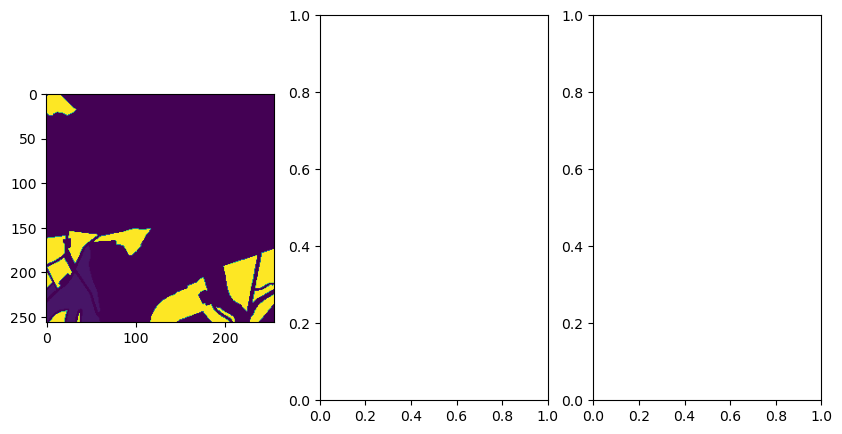

In [136]:
# label = '../data/label/3x_downsample/00060.png'
# pred = './results/partial-france/france_3x/2019_04/predictions/00060.npy'
# gt = '../data/image/3x_downsample/00060_2019_04.tif'
# fig, ax = plt.subplots(1, 3, figsize=(10, 5))
# ax[0].imshow(imageio.imread(label))
# pred = np.load(pred)
# # pred = (pred > 0.5)
# im = ax[1].imshow(pred)
# # plt.colorbar(im, ax=ax[1])  # Add colorbar to the second image
# ax[0].imshow(imageio.imread(label))
# ax[2].imshow(imageio.imread(gt))



# plt.show()

### Draw pred, bound and dist in the first batch

In [91]:
with torch.no_grad():
    for batch_i, (img, extent, boundary, distance, mask)in enumerate(test_loader):
        img, mask = img.to(device), mask.to(device)
        pred, bound, dist = model(img)
        break

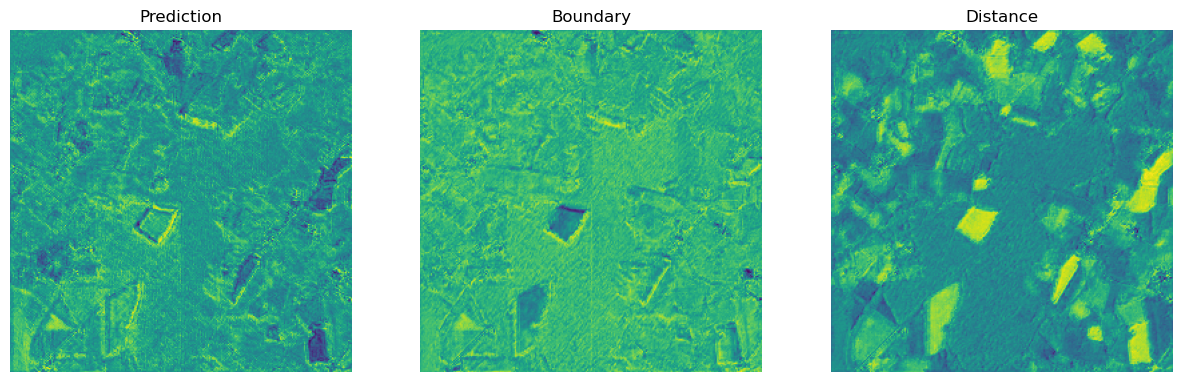

In [129]:
import matplotlib.pyplot as plt
import torch

i=7 # Control this cell and the next
# Assuming you have your test_loader and model set up
with torch.no_grad():
    for batch_i, (img, extent, boundary, distance, mask) in enumerate(test_loader):
        img, mask = img.to(device), mask.to(device)
        pred, bound, dist = model(img)

        # Move tensors to CPU for plotting
        pred_np = pred[i].squeeze().cpu().numpy()
        bound_np = bound[i].squeeze().cpu().numpy()
        dist_np = dist[i].squeeze().cpu().numpy()

        # Create a 1x3 subplot
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot predictions
        axs[0].imshow(pred_np,)
        axs[0].set_title('Prediction')
        axs[0].axis('off')

        # Plot boundaries
        axs[1].imshow(bound_np)
        axs[1].set_title('Boundary')
        axs[1].axis('off')

        # Plot distances
        axs[2].imshow(dist_np)
        axs[2].set_title('Distance')
        axs[2].axis('off')
        

        plt.show()

        # Break after the first batch
        break


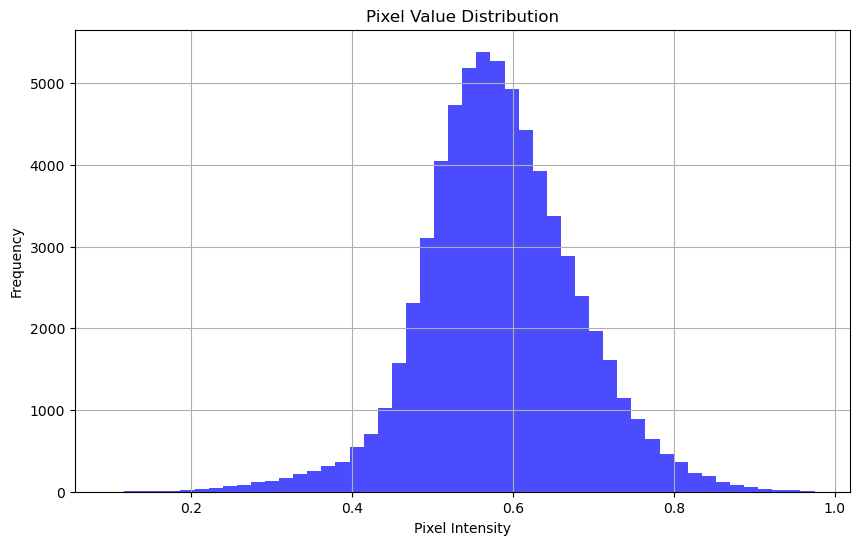

In [137]:
# Plot pixel distribution in pred.
def plot_image_distribution(image_tensor):
    """
    Plot the distribution of pixel values in the image tensor.
    """
    # Flatten the image tensor to get a 1D array of pixel values
    pixel_values = image_tensor.flatten()

    # Convert to numpy array if it's a tensor
    if isinstance(pixel_values, torch.Tensor):
        pixel_values = pixel_values.numpy()

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage with a sample image tensor
# Replace 'sample_image_tensor' with your actual image tensor
plot_image_distribution(pred_np)


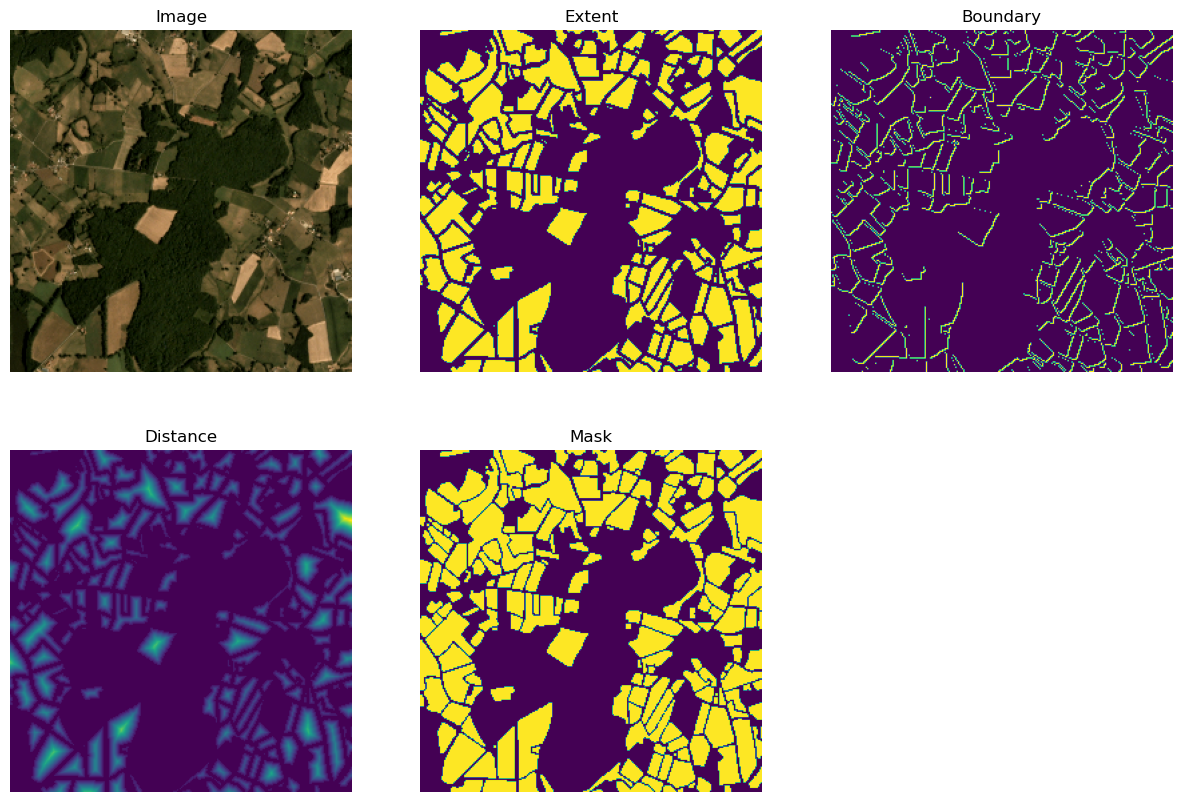

In [116]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def prepare_image_for_plotting(image_tensor):
    """
    Transpose the image tensor from (C, H, W) to (H, W, C) if it has 3 channels.
    """
    image_np = image_tensor.squeeze().numpy()
    if image_np.shape[0] == 3:  # Check if the image has 3 channels
        image_np = np.transpose(image_np, (1, 2, 0))  # Change to (H, W, C)
    return image_np

# Assuming you have your test_loader set up
with torch.no_grad():
    for batch_i, (img, extent, boundary, distance, mask) in enumerate(test_loader):
        # Prepare images for plotting
        img_np = prepare_image_for_plotting(img[i])
        extent_np = prepare_image_for_plotting(extent[i])
        boundary_np = prepare_image_for_plotting(boundary[i])
        distance_np = prepare_image_for_plotting(distance[i])
        mask_np = prepare_image_for_plotting(mask[i])

        # Create a 2x3 subplot
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))

        # Plot each type of data in its own subplot
        axs[0, 0].imshow(img_np)
        axs[0, 0].set_title('Image')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(extent_np)
        axs[0, 1].set_title('Extent')
        axs[0, 1].axis('off')

        axs[0, 2].imshow(boundary_np)
        axs[0, 2].set_title('Boundary')
        axs[0, 2].axis('off')

        axs[1, 0].imshow(distance_np)
        axs[1, 0].set_title('Distance')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(mask_np)
        axs[1, 1].set_title('Mask')
        axs[1, 1].axis('off')

        axs[1, 2].axis('off')

        plt.show()

        break


## Potential Bug
Model
1. Mismatch in the heads `head_cmtsk`. As some boundary feature is extracted well in the image of Distance prediction.
2. Pooling. Stitch is complicated.

Pipeline
1. Loss function. The function is not found in the original mxnet notebook, it is instead imported.
2. Distance calculation. Not sure abt 1-dist or dist.